# Quantum Teleportation with Noise (Qiskit)

Quantum teleportation transfers an unknown qubit state from Alice to Bob using:

* A shared Bell pair (entanglement)
* Measurement by Alice
* Classical communication of measurement results
* Conditional corrections by Bob

The state is not physically moved. Instead, classical information + entanglement recreate the state at Bob's location.

This notebook demonstrates quantum teleportation of a single qubit using Qiskit, including the effects of realistic noise (depolarizing and thermal relaxation). The fidelity of teleportation is evaluated using the density matrix formalism.

## Quantum Teleportation Circuit Breakdown
This circuit teleports the initial state of Alice's qubit (C) to Bob's qubit (B) using the shared Alice-Bob Bell pair (A-B) and classical communication.

We import:

* **NumPy / math** for numerical operations
* **Qiskit core** for circuit construction
* **AerSimulator** for noisy simulation
* **Noise models** to emulate hardware imperfections
* **Quantum information tools** for density matrices and fidelity

## 1. Import Libraries

In [1]:
import numpy as np
from math import sqrt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.circuit.library import HGate, CXGate, XGate, YGate, ZGate

from qiskit import transpile
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace

## 2. Create Quantum & Classical Registers

* qC → Alice's unknown qubit
* qA → Alice's half of the Bell pair
* qB → Bob's half of the Bell pair

We also create classical registers cC, cA, CB to store their measurements.

In [2]:
qC=QuantumRegister(1, name="Alice_C") # state to teleport
qA=QuantumRegister(1, name="Alice_A") # part of Bell pair (Alice)
qB=QuantumRegister(1, name="Bob_B") # part of Bell pair (Bob)

cC=ClassicalRegister(1, name="alice_c") # Alice measurement 1
cA=ClassicalRegister(1, name="alice_a") # Alice measurement 2
cB=ClassicalRegister(1, name="bob_b") # Bob measurement 

qc=QuantumCircuit(qC, qA, qB, cC, cA, cB)

## 3. Prepare the Unknown State to Teleport

Example unknown state: $|+⟩ = (|0⟩ + |1⟩)/\sqrt(2)$

In [3]:
#Prepare state Alice's C 
amp=[1/sqrt(2),1/sqrt(2)]
qc.initialize(amp, qC[0])
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

## 4. Create the Bell Pair Between Alice (qA) and Bob (qB)

Alice and Bob establish an entangled pair, typically the $|\Phi^+\rangle$ Bell state, by
* ApplyIing Hadamard on qA → to create superposition
* Applying CNOT between qA → qB → to entangle 

In [4]:
#Creating Bell's pair
qc.append(HGate(), [qA[0]])
qc.append(CXGate(), [qA[0],qB[0]])
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

Resulting State on $qA$ and $qB$:$$|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

## 5. Alice Performs Bell Measurement

Alice performs the analysis stage on her two qubits: the source qubit ($qC$) and her Bell partner ($qA$). This transforms the overall state into a form where Bob's qubit ($qB$) holds the required state rotation, dependent on Alice's classical measurement results.

She performs operations to project the system into Bell basis:
* CNOT from unknown qubit → Alice's qubit
* Hadamard on unknown qubit.
  
Then she measures both.

In [5]:
#Bell measurement on Alice's C and A states
qc.append(CXGate(), [qC[0],qA[0]])
qc.append(HGate(), [qC[0]])
qc.barrier()

# Measure and send results (classical communication)
qc.measure(qC[0], cC[0])
qc.measure(qA[0], cA[0])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

## 6. Bob Applies Conditional Corrections (Dynamic Circuit)

Bob receives the two classical bits $(cA, cC)$ and applies a corresponding unitary transformation (rotation) to his qubit ($qB$) to reconstruct the original state $|\psi\rangle$.

Depending on Alice’s measurement results:

* If cA == 1 → apply X
* If cC == 1 → apply Z

This reconstructs the original unknown state.

That is, if
* cA=0, cC =0, apply **I Gate**
* cA=0, cC =1, apply **ZGate**
* cA=1, cC =0, apply **X Gate**
* cA=1, cC =1, apply **ZX Gate**

In [6]:
# Conditional corrections on Bob's qubit
with qc.if_test((cC[0], 1)):
    qc.z(qB[0])
with qc.if_test((cA[0], 1)):
    qc.x(qB[0])

## 8. Saving the Density Matrix

We save the full density matrix to analyze Bob’s final state.

In [7]:
qc.save_density_matrix()

## 9. Ideal Teleported State

This is the reference state used to compute teleportation fidelity.

In [8]:
#Define ideal teleported state
ideal_state = Statevector([1/np.sqrt(2), 1/np.sqrt(2)])

## 10. Noise Model Parameters

In a real quantum processor, qubits are not perfectly isolated. Their states gradually decay and lose coherence due to interactions with the environment. To realistically simulate teleportation, we explicitly model these effects.

Physical meaning of parameters:

* T1 (Energy relaxation time): 
Time scale over which |1⟩ → |0⟩ decay occurs.
* T2 (Dephasing time): 
Time scale over which relative phase information is lost.
* Gate times: 
Longer gate durations allow more decoherence to accumulate.
* Depolarizing probabilities (p1, p2): 
Model stochastic gate imperfections that randomly perturb the qubit state.

In [9]:
#Defining Noise parameters
T1 = 50e3      # ns
T2 = 70e3      # ns (We can change values of T2, such that, T2<=2T1)

gate_time_1q = 100
gate_time_2q = 600

p1 = 0.001
p2 = 0.03


## 11. Building the Noise Model

We now combine two independent noise mechanisms:

### (a) Depolarizing Noise

This models control errors in gates. With probability p, the qubit is replaced by a maximally mixed state.

* Applied to all single-qubit gates: H, X, Z
* Stronger depolarization for two-qubit gates (CX), which are typically noisier

### (b) Thermal Relaxation Noise

This models environment-induced decoherence during gate execution.

* Single-qubit thermal noise for 1-qubit gates
* Tensor-product thermal noise for 2-qubit gates

These two noise sources act sequentially, closely mimicking real hardware behavior.

In [10]:
noise_model = NoiseModel()

In [11]:
# Depolarizing errors
error_1q = depolarizing_error(p1, 1)
error_2q = depolarizing_error(p2, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'z'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

In [12]:
# Thermal relaxation errors
thermal_1q = thermal_relaxation_error(T1, T2, gate_time_1q)

thermal_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(thermal_relaxation_error(T1, T2, gate_time_2q))

noise_model.add_all_qubit_quantum_error(thermal_1q, ['h', 'x', 'z'])
noise_model.add_all_qubit_quantum_error(thermal_2q, ['cx'])

## 12. Noisy Simulation (Density Matrix)

Because noise creates mixed quantum states, we cannot use statevectors. Instead, we simulate using the density matrix formalism.

* `method="density_matrix"` ensures full open-system evolution
* The simulator internally applies noise after every gate

This gives access to the complete quantum state, including classical randomness induced by noise.

In [13]:
noisy_sim = AerSimulator(method="density_matrix", noise_model=noise_model)
tqc = transpile(qc, noisy_sim, optimization_level=0)
result = noisy_sim.run(tqc).result()

## 13. Extracting Bob’s State

The saved density matrix contains all three qubits (Alice_C, Alice_A, Bob_B).

Teleportation success is judged only on Bob’s qubit, so we remove Alice’s degrees of freedom using a partial trace.

Conceptually:
* Trace out Alice_C and Alice_A
* Retain Bob’s reduced density matrix

This operation removes both quantum entanglement and classical correlations with Alice.

In [14]:
#Extracting Bob's state
rho = result.data(0)['density_matrix']
bob_state = partial_trace(rho, [0, 1])

## 14. Teleportation Fidelity

Fidelity measures how close Bob’s final state is to the ideal teleported state.

For a mixed state ρ and pure state |ψ⟩:

F = ⟨ψ| ρ |ψ⟩
* F = 1 → perfect teleportation
* F < 1 → degradation due to noise

This is the central quantitative figure of merit in noisy quantum communication protocols.

In [15]:
#Finding Fidelity
fidelity = state_fidelity(bob_state, ideal_state)
print("Teleportation fidelity:", fidelity)

Teleportation fidelity: 0.9549134431488642


## 15. Measuring Bob’s Qubit

While fidelity is a quantum-mechanical metric, experiments ultimately yield classical measurement outcomes.

We therefore:
* Copy the teleportation circuit
* Measure only Bob’s qubit
* Repeat the experiment many times (shots = 4096)

This mimics what would be observed in a real laboratory experiment.

{'1 1 0': 492, '1 0 1': 497, '0 0 1': 518, '1 0 0': 521, '0 0 0': 544, '0 1 1': 508, '0 1 0': 487, '1 1 1': 529}


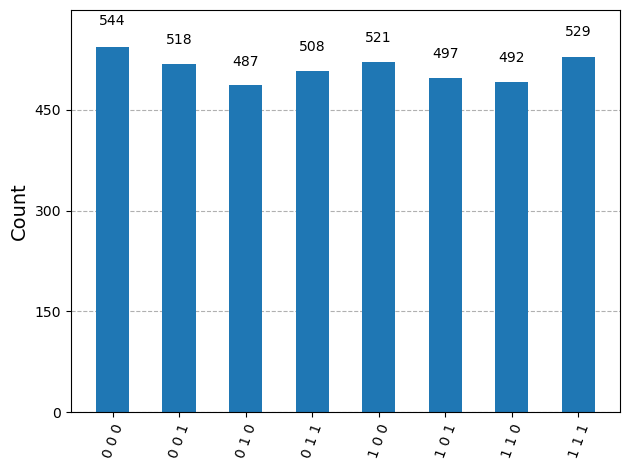

In [16]:
#To measure Bob's outcomes
qc_bob = qc.copy()
qc_bob.measure(qB, qc_bob.clbits[-1])


#Running on simulation
sim = AerSimulator(noise_model=noise_model)
tqc_bob = transpile(qc_bob, sim)
result_bob = sim.run(tqc_bob, shots=4096).result()
counts = result_bob.get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

#This gives the results of all three qubits. TO measure only Bob's, do it in the below way

## 16. Extracting Bob-Only Statistics and Visualisation

Qiskit returns measurement results for all classical registers combined.

However, teleportation success depends only on Bob’s result. We therefore:

* Parse the full measurement bitstring
* Extract the last classical bit (Bob)
* Accumulate counts for |0⟩ and |1⟩

This isolates Bob’s statistics from Alice’s measurement randomness.

### Visualisation

The histogram shows the probability distribution of Bob’s measurement outcomes.

For the input state:

|ψ⟩ = (|0⟩ + |1⟩)/√2

Ideal teleportation would produce equal probabilities for |0⟩ and |1⟩.

Deviations from this indicate the combined effect of gate noise and decoherence.

{'0': 2044, '1': 2052}


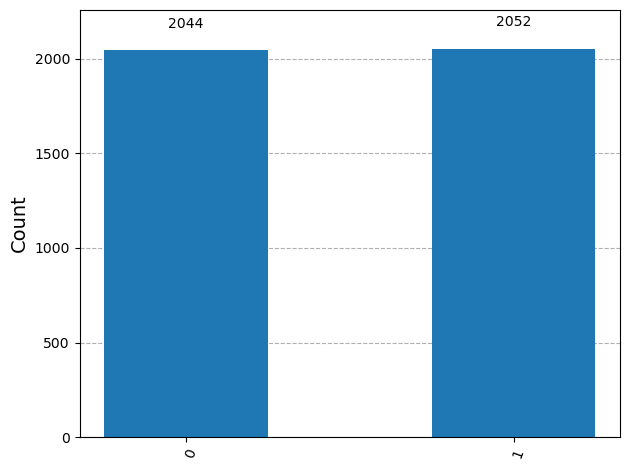

In [17]:
#Bob only measurement
bob_counts = {'0': 0, '1': 0}

for bitstring, count in counts.items():
    bob_bit = bitstring.split()[-1]   # Bob is last register
    bob_counts[bob_bit] += count
print(bob_counts)
plot_histogram(bob_counts)

## 18. Conclusion

This notebook demonstrates:

* Quantum teleportation using dynamic circuits
* Simulation under realistic noise models
* Evaluation using density matrices and fidelity
* Such simulations are essential for understanding teleportation performance on near-term quantum hardware.